In [119]:
#import libraries
import os
import glob
import numpy as np
from numpy import unique
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib import pyplot
import keras
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score
import tensorflow
%matplotlib inline

# important metrics and clusters
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import (
    DBSCAN,
    KMeans,
    AgglomerativeClustering,
    MeanShift,
    AffinityPropagation,
    Birch,
    MiniBatchKMeans,
    OPTICS,
    SpectralClustering
)
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    rand_score,
    fowlkes_mallows_score,
)

In [6]:
np.random.seed(42)

In [38]:
data = []
label = []
path = "/content/drive/MyDrive/Colab_Notebooks/Maize/train/"
c = 0
d = 0
IMG_SIZE = 32

for file in os.listdir(path):
    img=cv2.imread(path+file)
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    img=img.astype('float32')

    if file[:9]=='army_worm':
        if c==80: continue
        c+=1
        label.append("army_worm")
    else:
        if d==80: continue
        d+=1
        label.append("cutworm")

    data.append(img)
data = np.array(data)

In [39]:
data_label = []
for i in label:
    if i=="army_worm": data_label.append(0)
    else: data_label.append(1)
data_label = np.array(data_label)

In [40]:
# Normalization
data = data/255.0

# k-means accept data with less than 3 dimensions
reshaped_data = data.reshape(len(data),-1)
reshaped_data.shape

(160, 3072)

In [41]:
# Applying K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(reshaped_data)
kmeans.cluster_centers_.shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(2, 3072)

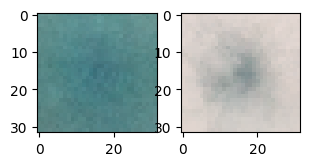

In [42]:
# This is how our centroids look like
kmeans.cluster_centers_ = kmeans.cluster_centers_*255
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(2):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.imshow(kmeans.cluster_centers_[i].astype(int).reshape(32,32,3))

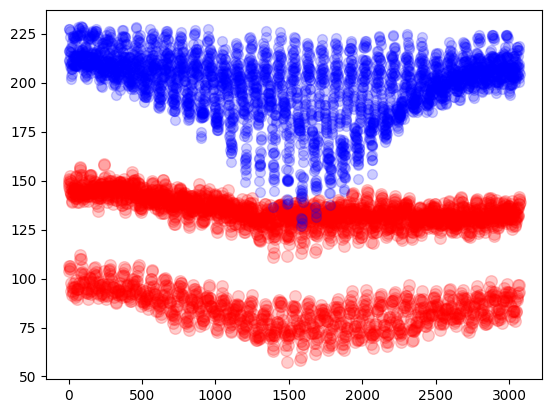

In [43]:
# Scatter Plot for both the centroids
x_data = [i for i in range(3072)]
plt.scatter(x_data,kmeans.cluster_centers_[0], color = 'red',alpha=0.2,s=70)
plt.scatter(x_data,kmeans.cluster_centers_[1] , color = 'blue',alpha=0.2,s=50)

In [44]:
# Since K-Means Does not know about our labels we have to change labels of k-means according to our usage

# mapping labels from cluster to original labels
def get_reference_dict(clusters,data_label):
    reference_label = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label

# Mapping predictions to original labels
def get_labels(clusters,reference_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels


In [45]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)

In [46]:
# Accuracy Score for right predictions
print(accuracy_score(predicted_labels,data_label))

0.50625


Text(0.5, 23.52222222222222, 'predicted label')

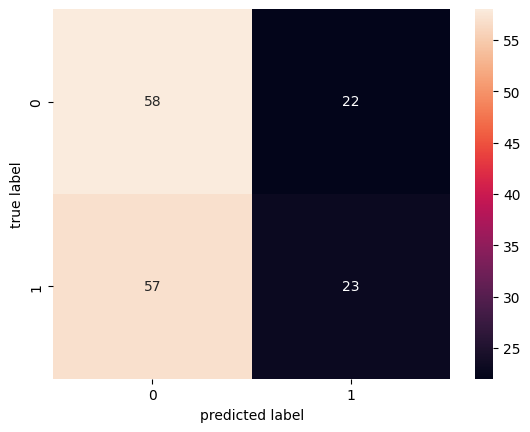

In [47]:
mat = confusion_matrix(data_label,predicted_labels)
sns.heatmap(mat, annot=True)
plt.ylabel('true label')
plt.xlabel('predicted label')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy for k = 2:  0.50625


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy for k = 16:  0.7625


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy for k = 64:  0.90625


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy for k = 100:  0.925


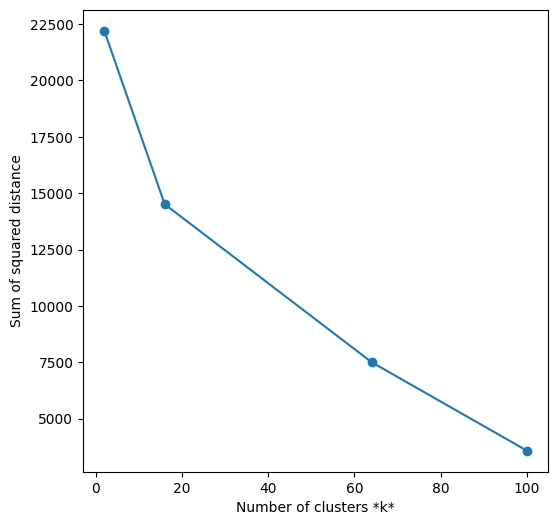

In [49]:
# elbow method
# squared distance
sse = []
list_k = [2,16,64,100]

for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(reshaped_data)
    sse.append(km.inertia_)

    reference_labels = get_reference_dict(clusters,data_label)
    predicted_labels = get_labels(clusters,reference_labels)

    print(f"Accuracy for k = {k}: ", accuracy_score(predicted_labels,data_label))

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [81]:
model = tensorflow.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))

In [82]:
# Extract features from resnet50
def extract_vector(data_holder):
    resnet_feature_list = []

    for im in data_holder:
        im = image.img_to_array(im)
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
        resnet_feature = model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
        resnet_feature_list.append(resnet_feature_np.flatten())

    return np.array(resnet_feature_list)





In [83]:
# Extract vectors and apply kmeans
array = extract_vector(data)
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(array)

1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [84]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)

In [85]:
print(accuracy_score(predicted_labels,data_label))

0.5375


Text(0.5, 23.52222222222222, 'predicted label')

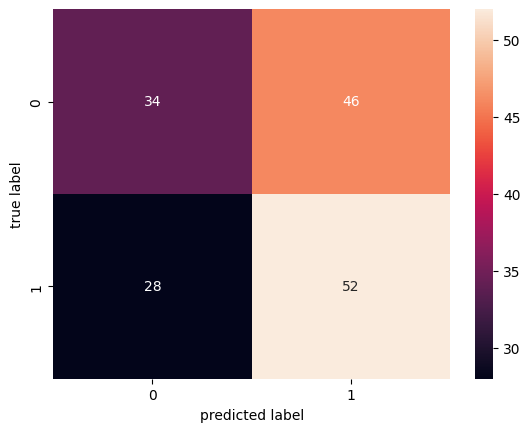

In [86]:
mat = confusion_matrix(data_label,predicted_labels )
sns.heatmap(mat, annot=True)
plt.ylabel('true label')
plt.xlabel('predicted label')

1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy for k = 2:  0.54375
1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy for k = 16:  0.70625
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy for k = 64:  0.80625
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy for k = 100:  0.86875


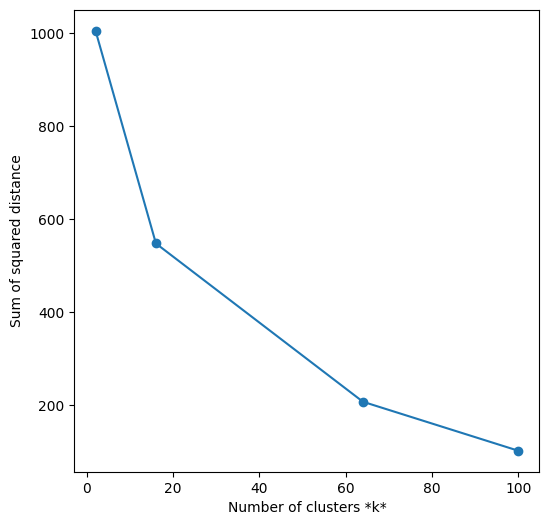

In [87]:
# elbow method
# squared distance
sse = []
list_k = [2,16,64,100]

for k in list_k:
    array = extract_vector(data)
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(array)
    sse.append(km.inertia_)

    reference_labels = get_reference_dict(clusters,data_label)
    predicted_labels = get_labels(clusters,reference_labels)

    print(f"Accuracy for k = {k}: ", accuracy_score(predicted_labels,data_label))

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

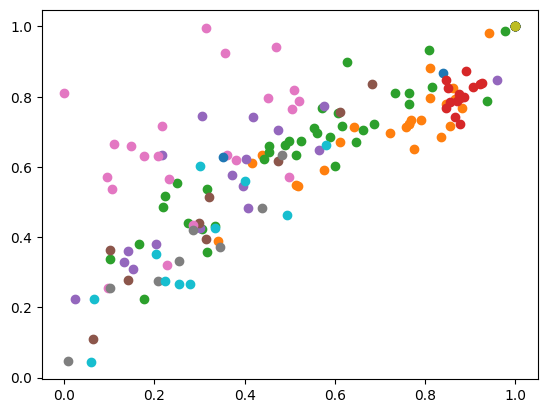

In [95]:
model = AffinityPropagation(damping=0.9)

# fit the model
model.fit(reshaped_data)

# assign a cluster to each example
yhat = model.predict(reshaped_data)

# retrieve unique clusters
clusters = unique(yhat)

# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(reshaped_data[row_ix, 0], reshaped_data[row_ix, 1])
# show the plot
pyplot.show()

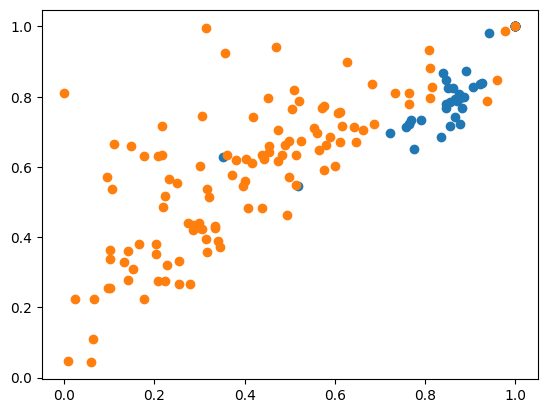

In [97]:
model = AgglomerativeClustering(n_clusters=2)

# fit the model
# assign a cluster to each example
yhat = model.fit_predict(reshaped_data)

# retrieve unique clusters
clusters = unique(yhat)

# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(reshaped_data[row_ix, 0], reshaped_data[row_ix, 1])
# show the plot
pyplot.show()


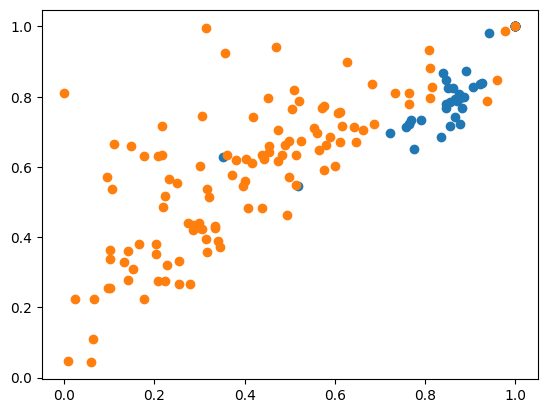

In [99]:
model = Birch(threshold=0.01, n_clusters=2)

# fit the model
model.fit(reshaped_data)

# assign a cluster to each example
yhat = model.predict(reshaped_data)

# retrieve unique clusters
clusters = unique(yhat)

# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(reshaped_data[row_ix, 0], reshaped_data[row_ix, 1])
# show the plot
pyplot.show()

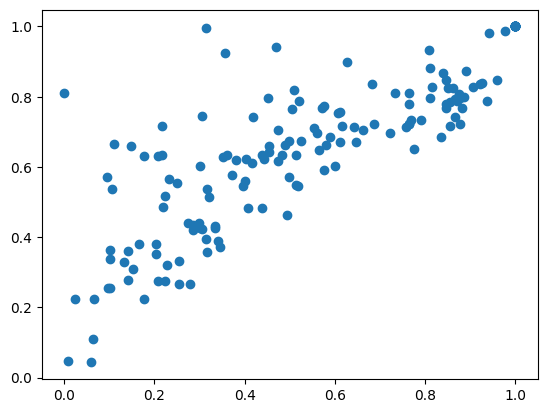

In [118]:
model = DBSCAN(eps=0.30, min_samples=2)

# fit the model
# assign a cluster to each example
yhat = model.fit_predict(reshaped_data)

# retrieve unique clusters
clusters = unique(yhat)

# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(reshaped_data[row_ix, 0], reshaped_data[row_ix, 1])
# show the plot
pyplot.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


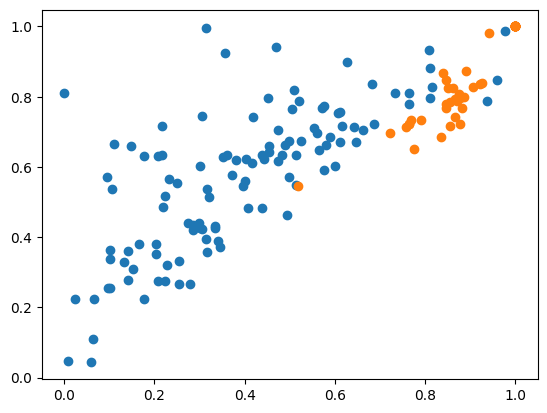

In [103]:
model = MiniBatchKMeans(n_clusters=2)

# fit the model
model.fit(reshaped_data)

# assign a cluster to each example
yhat = model.predict(reshaped_data)

# retrieve unique clusters
clusters = unique(yhat)

# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(reshaped_data[row_ix, 0], reshaped_data[row_ix, 1])
# show the plot
pyplot.show()

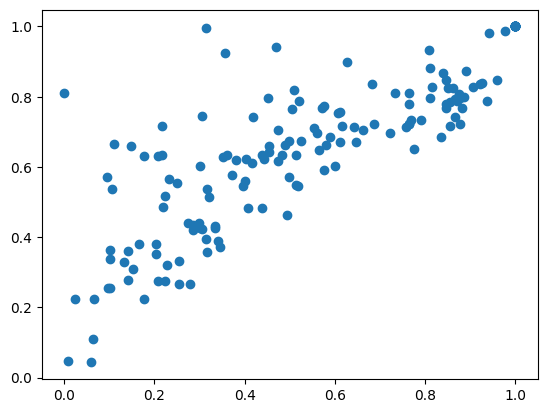

In [108]:
model = MeanShift()

# fit the model
yhat = model.fit_predict(reshaped_data)

# retrieve unique clusters
clusters = unique(yhat)

# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(reshaped_data[row_ix, 0], reshaped_data[row_ix, 1])
# show the plot
pyplot.show()

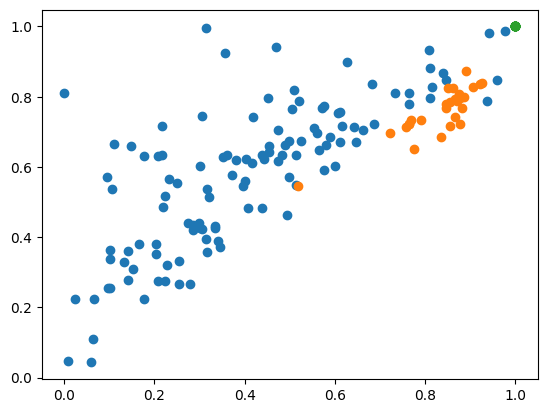

In [109]:
model = OPTICS(eps=0.8, min_samples=10)

# assign a cluster to each example
yhat = model.fit_predict(reshaped_data)

# retrieve unique clusters
clusters = unique(yhat)

# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(reshaped_data[row_ix, 0], reshaped_data[row_ix, 1])
# show the plot
pyplot.show()

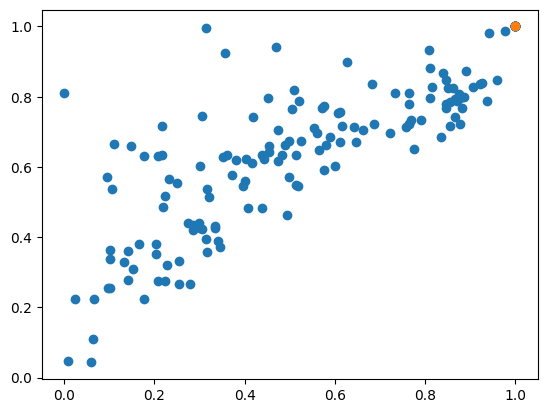

In [111]:
model = SpectralClustering(n_clusters=2)

# assign a cluster to each example
yhat = model.fit_predict(reshaped_data)

# retrieve unique clusters
clusters = unique(yhat)

# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(reshaped_data[row_ix, 0], reshaped_data[row_ix, 1])
# show the plot
pyplot.show()

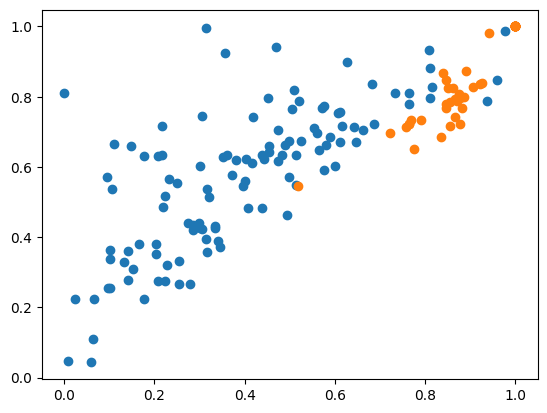

In [112]:
model = GaussianMixture(n_components=2)
model.fit(reshaped_data)

# assign a cluster to each example
yhat = model.predict(reshaped_data)

# retrieve unique clusters
clusters = unique(yhat)

# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(reshaped_data[row_ix, 0], reshaped_data[row_ix, 1])
# show the plot
pyplot.show()